<a href="https://colab.research.google.com/github/martings/ML_Practica_y_Herramientas/blob/main/Frag_y_Train_red_genoma_E_coli_one_heat_enc_IADN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Un pequeño experimento de one-hot-encoding

La idea es fragmentar genomas procariotas conocidos y anotados para encontrar la informacion que puede determinar qeu una secuencia sea o no un gen.

In [ ]:
!pip install Bio
!pip install pybedtools --pre --no-binary pybedtools
!pip install gffutils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 99.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 65.3 MB/s eta 0:00:00
  Created wheel for pybedtools: filename=pybedtools-0.9.0-cp310-cp310-linux_x86_64.whl size=14248367 sha256=85b2d3a300e72571077ca2d53745b8e28642b074a5087595847155c0c0066b9f
  Stored in directory: /root/.cache/pip/wheels/50/a7/83/8f6b841c60977cbd76f54f30f5b9e11159150d73a0a8fa42ff
Successfully built pybedtools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.5/41.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 16.0 MB/s eta 0:00:00


Para esto a partir de la secuencia fasta y un archivo de anotado, fragmentamos el genoma elegido con un bin_size definido sin redundancia.

In [ ]:
import pandas as pd
import gffutils
import pybedtools
from Bio import SeqIO

# Rutas de los archivos GFF y FASTA de E. coli
gff_file = "/content/genomic.gff"
fasta_file = "/content/GCF_000008865.2_ASM886v2_genomic.fna"
bin_size= 50
# Cargar el archivo GFF utilizando gffutils
db = gffutils.create_db(gff_file, dbfn='temp.db', force=True, keep_order=True, merge_strategy='merge')

# Crear una lista de tuplas con las posiciones, secuencias y etiquetas
data = []
with open(fasta_file, "r") as f:
    for record in SeqIO.parse(f, "fasta"):
        seq_id = record.id
        sequence = str(record.seq)
        for feature in db.region(seq_id):
            start = feature.start - 1
            end = feature.end
            gene_present = True if feature.featuretype == 'gene' else False
            for i in range(start, end, bin_size):
                pos = i + 1
                seq_fragment = sequence[i:i + bin_size]
                data.append((pos, seq_fragment, gene_present))

# Crear un DataFrame a partir de los datos
df = pd.DataFrame(data, columns=["Posición", "Secuencia", "Etiqueta"])

# Imprimir el DataFrame resultante
print(df)
conteo_true = df["Etiqueta"].value_counts()[True]

# Imprimir el resultado
print("Cantidad de True:", conteo_true)

        Posición                                          Secuencia  Etiqueta
0              1  AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATT...     False
1             51  AAAGAGTCTCTGACAGCAGCTTCTGAACTGGTTACCTGCCGTGAGT...     False
2            101  TAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGG...     False
3            151  GCGCACAGACAGATAAAAATTACAGAGTACACAACATCCATGAAAC...     False
4            201  TAGCACCACCATTACCACCACCATCACCACCACCATCACCATTACC...     False
...          ...                                                ...       ...
336908     94977                                                        False
336909     95027                                                        False
336910     95077                                                        False
336911     95127                                                        False
336912     95177                                                        False

[336913 rows x 3 columns]
Cantidad de True: 98371


Uso la estrategia de one hot encoding, donde codeo los nucleatidos posibles. Los convierto en tensores para su mejor uso y corro una red rapida para ver los resultados.

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define el diccionario para mapear los nucleótidos a su representación one-hot
nucleotide_dict = {'A': [1, 0, 0, 0],
                   'C': [0, 1, 0, 0],
                   'G': [0, 0, 1, 0],
                   'T': [0, 0, 0, 1],
                   'N': [0, 0, 0, 0]}  # a veces hay Ns

# Define la función para codificar one-hot una sola secuencia de ADN
def one_hot_encode(seq):
    if len(seq) < bin_size:
        seq = seq + 'N' * (bin_size - len(seq))
    elif len(seq) > bin_size:
        seq = seq[:bin_size]
    return np.array([nucleotide_dict[nuc] for nuc in seq])

# Aplica la codificación one-hot a la columna "Secuencia" del DataFrame
df["Secuencia_encoded"] = df["Secuencia"].apply(one_hot_encode)

# Convierte las secuencias codificadas a un array numpy
sequences = np.array(df["Secuencia_encoded"].tolist())

# Convierte las etiquetas a un array numpy
labels = np.array(df["Etiqueta"].astype(int))

# Divide el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Convierte los arreglos NumPy a Tensores
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Crea el modelo de red neuronal
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(bin_size, 4)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compila el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrena el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evalúa el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)


Epoch 1/10
8423/8423 [==============================] - 126s 15ms/step - loss: 0.6057 - accuracy: 0.7077 - val_loss: 0.6032 - val_accuracy: 0.7087
Epoch 2/10
8423/8423 [==============================] - 120s 14ms/step - loss: 0.6037 - accuracy: 0.7079 - val_loss: 0.6028 - val_accuracy: 0.7087
Epoch 3/10
8423/8423 [==============================] - 115s 14ms/step - loss: 0.6033 - accuracy: 0.7079 - val_loss: 0.6025 - val_accuracy: 0.7087
Epoch 4/10
8423/8423 [==============================] - 111s 13ms/step - loss: 0.6031 - accuracy: 0.7079 - val_loss: 0.6028 - val_accuracy: 0.7086
Epoch 5/10
8423/8423 [==============================] - 114s 14ms/step - loss: 0.6029 - accuracy: 0.7079 - val_loss: 0.6041 - val_accuracy: 0.7086
Epoch 6/10
8423/8423 [==============================] - 127s 15ms/step - loss: 0.6025 - accuracy: 0.7079 - val_loss: 0.6033 - val_accuracy: 0.7086
Epoch 7/10
8423/8423 [==============================] - 120s 14ms/step - loss: 0.6024 - accuracy: 0.7079 - val_loss: 0

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


ValueError: ignored

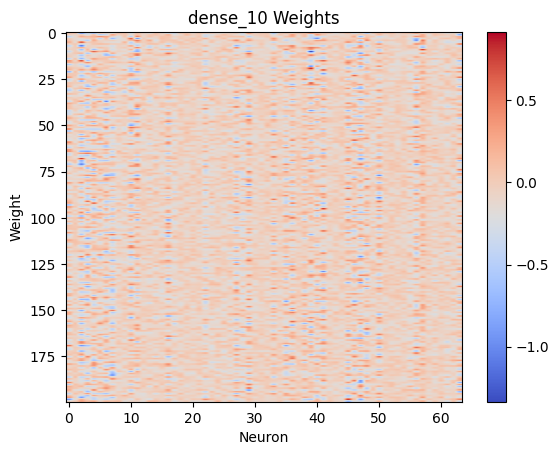

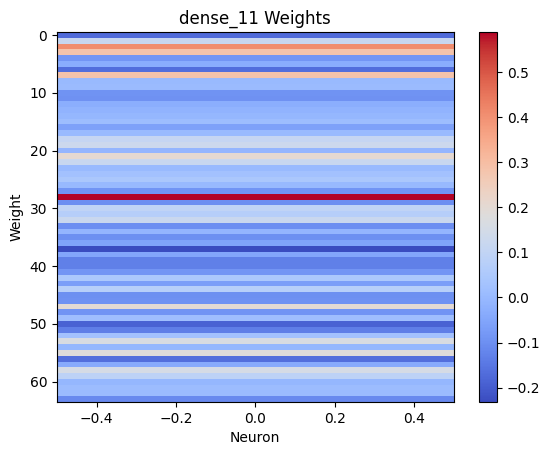

In [ ]:
import matplotlib.pyplot as plt

# Obtén la lista de capas del modelo
layers = model.layers

# Itera sobre todas las capas y visualiza los pesos
for layer in layers:
    weights = layer.get_weights()
    if weights:  # Verifica si la capa tiene pesos
        layer_name = layer.name
        plt.figure()
        plt.title(layer_name + ' Weights')
        plt.xlabel('Neuron')
        plt.ylabel('Weight')
        plt.imshow(weights[0], cmap='coolwarm', aspect='auto')
        plt.colorbar()
        plt.show()


2106/2106 [==============================] - 10s 5ms/step


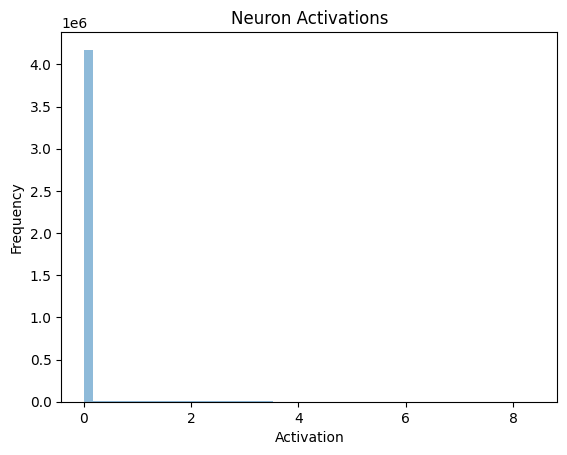

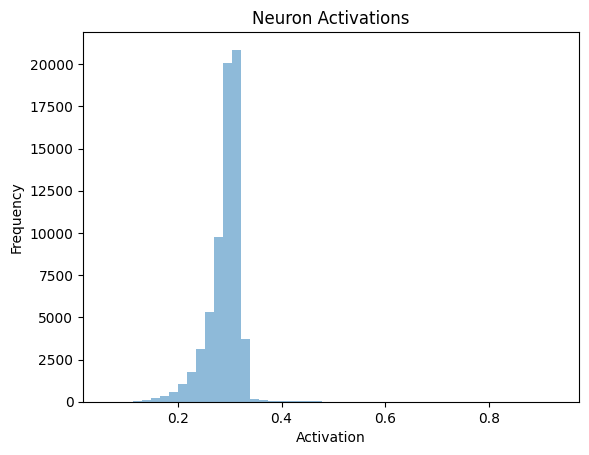

In [ ]:
import matplotlib.pyplot as plt

# Obtén las activaciones de las capas ocultas
layer_outputs = [layer.output for layer in model.layers if 'dense' in layer.name]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_test)

# Genera los histogramas de las activaciones de las neuronas
for layer_activation in activations:
    num_neurons = layer_activation.shape[1]
    plt.figure()
    plt.title('Neuron Activations')
    plt.xlabel('Activation')
    plt.ylabel('Frequency')
    plt.hist(layer_activation.flatten(), bins=50, alpha=0.5)
    plt.show()


1/1 [==============================] - 1s 941ms/step


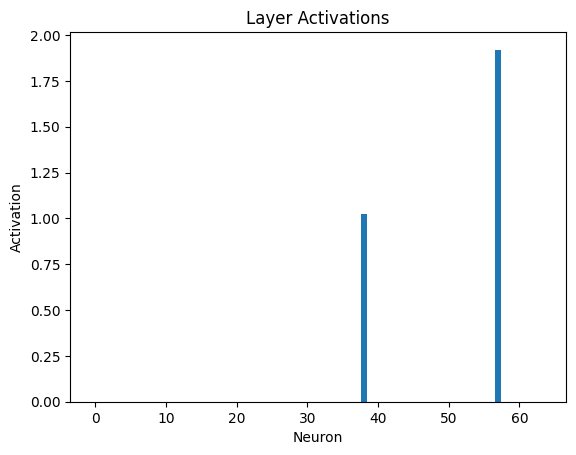

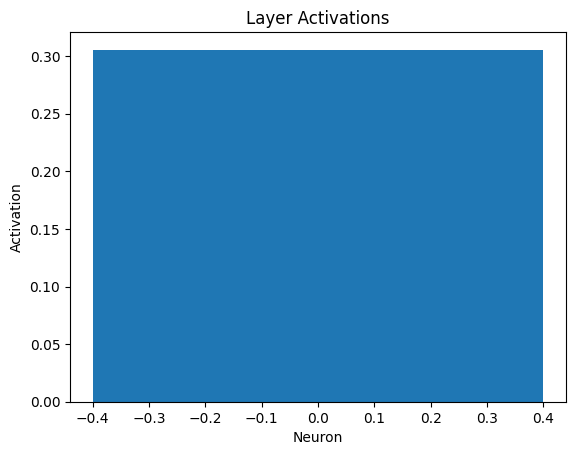

In [ ]:
import tensorflow.keras.backend as K

# Crea un nuevo modelo que devuelve las salidas de las capas ocultas
layer_outputs = [layer.output for layer in model.layers if 'dense' in layer.name]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

# Obtén las salidas intermedias para una muestra de datos
sample_index = 0  # Índice de la muestra de datos a analizar
activations = activation_model.predict(X_test[sample_index:sample_index+1])

# Visualiza las salidas intermedias de las capas ocultas
for layer_activation in activations:
    num_neurons = layer_activation.shape[1]
    plt.figure()
    plt.title('Layer Activations')
    plt.xlabel('Neuron')
    plt.ylabel('Activation')
    plt.bar(range(num_neurons), layer_activation.flatten())
    plt.show()

In [ ]:
#Pruebo otro tipo de arquitectura de la red
# Definir la arquitectura del modelo
inputs = tf.keras.Input(shape=(100, 4))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)


# Compila el modelo
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrena el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evalúa el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/10
4279/4279 [==============================] - 56s 13ms/step - loss: 0.5908 - accuracy: 0.7062 - val_loss: 0.6417 - val_accuracy: 0.6960
Epoch 2/10
4279/4279 [==============================] - 42s 10ms/step - loss: 0.5891 - accuracy: 0.7064 - val_loss: 0.6456 - val_accuracy: 0.6892
Epoch 3/10
4279/4279 [==============================] - 44s 10ms/step - loss: 0.5875 - accuracy: 0.7061 - val_loss: 0.6468 - val_accuracy: 0.6940
Epoch 4/10
4279/4279 [==============================] - 67s 16ms/step - loss: 0.5856 - accuracy: 0.7064 - val_loss: 0.6519 - val_accuracy: 0.6899
Epoch 5/10
4279/4279 [==============================] - 71s 17ms/step - loss: 0.5841 - accuracy: 0.7064 - val_loss: 0.6556 - val_accuracy: 0.6872
Epoch 6/10
4279/4279 [==============================] - 63s 14ms/step - loss: 0.5827 - accuracy: 0.7066 - val_loss: 0.6608 - val_accuracy: 0.6873
Epoch 7/10
4279/4279 [==============================] - 54s 13ms/step - loss: 0.5816 - accuracy: 0.7067 - val_loss: 0.6679 -